In [92]:
from math import ceil
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from glm.glm import GLM
from glm.families import Gaussian

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Linear Regression Assumptions and Inference

We discussed, at the end of the first lecture on linear regression, that regression could be used for **inference**.  To accomplish this, we need a better understanding of the probabalistic nature of linear regression, i.e., how we can think about linear regression as a **statistical model**.

Let's now go back to that topic, and see what additional assumptions and checks we must make to use linear regression in this way.

## The Linear Regression Assumptions

Linear regression is often presented along with a list of assumptions.

#### The Linear Regression Assumptions:
  - Linearity
  - Linear Independence
  - Independence
  - Homoskedacity
  - Normal Distribution of Errors
  
These assumptions are not all needed, nor must they all be checked, for all applications of linear regression.  Indeed, when used as a **predictive** model, only the first is really needed (though some of the others bear consequences when blatantly violated).

We will take these assumptions in turn, and discuss what the assumption means, and what can happen when it is violated.

## The Linearity Assumption

Recall that the "linear" in the name "linear regression" does **not** mean that the model is attempting to fit a linear function of the **raw features**.  Instead, it means that the model is a linear function of the **transformed features**.

So, the **linearity assumption** in regression says that the **model fits the data well**.  I.e., that $y$ is a **linear function of the (possibly transformed) features in the model**.  Of course, $y$ cannot be an exact linear function, because there is some randomness involved, but this should be the **only reason** that $y$ is not a linear function of the features.

$$ y = \beta_0 + \beta_1 f_1 + \beta_2 f_2 + \cdots + \beta_k f_k + \text{noise} $$

The residuals vs. feature plots we looked at in the linear regression day can be used to assess this asumption.

Suppose we create some data in which a feature enters in a non-linear manner, but then we fit to the data without using the proper feature transformations.

In [4]:
x = np.random.uniform(-2, 4, size=500)
y = 1 + x - 0.5 * x * x + np.random.normal(size=500)

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

y_hat = model.predict(x.reshape(-1, 1))

In [5]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

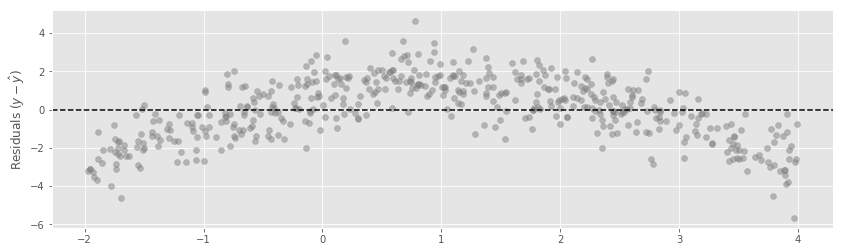

In [6]:
fig, ax = plt.subplots(figsize=(14, 4))
residual_plot(ax, x, y, y_hat)

We clearly do not have a band evenly spaced around the center line. This type of plot indicates that something is missing from the model.

By fitting a transformation of the predictor, we can recapture the nice residuals.

In [7]:
X = np.empty((len(x), 2))
X[:, 0] = x
X[:, 1] = x**2

model = LinearRegression()
model.fit(X, y)

y_hat = model.predict(X)

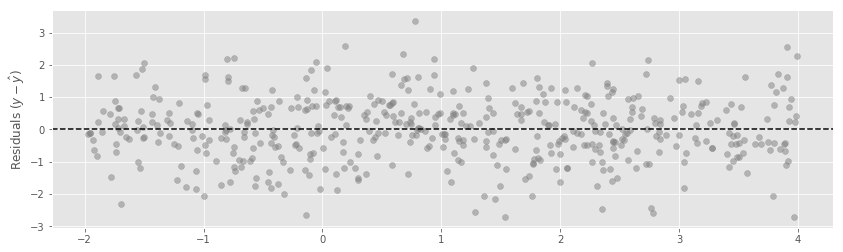

In [8]:
fig, ax = plt.subplots(figsize=(14, 4))
residual_plot(ax, x, y, y_hat)

## Consistency: The Independence Assumption

The **consistency** of linear regression adresses the effect of gathering more data.  We would like the regression to become more and more accurate as we feed it more training data.

But accurate with reference to what?

**Question:** Accurate with reference to what?

The idea is this:  if our data we **truly** generated from a random process like this:

$$ y \mid X \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{random_noise} $$

Then the coefficeints we get from fitting a linear regression can be considered as **estimates of the true parameters**:

$$ \underbrace{\hat \beta_k}_{\text{The Coefficients from the Fit Regression}} \approx \underbrace{\beta_k}_{\text{The True Parameters}} $$

**Consistency** is the statement that this approximation gets **better** as we collect more data.

In [11]:
def plot_regressions(ax, n, num=50):
    for k in range(num):
        x = np.random.uniform(-1, 1, size=n)
        y = 2*x + np.random.normal(0.0, 1.0, size=n)
        if k == 0:
            ax.scatter(x, y, color="grey")
        model = LinearRegression()
        model.fit(x.reshape(-1, 1), y)
        t = np.linspace(-1, 1, num=250)
        ax.plot(t, model.predict(t.reshape(-1, 1)), color="grey", alpha=0.5)

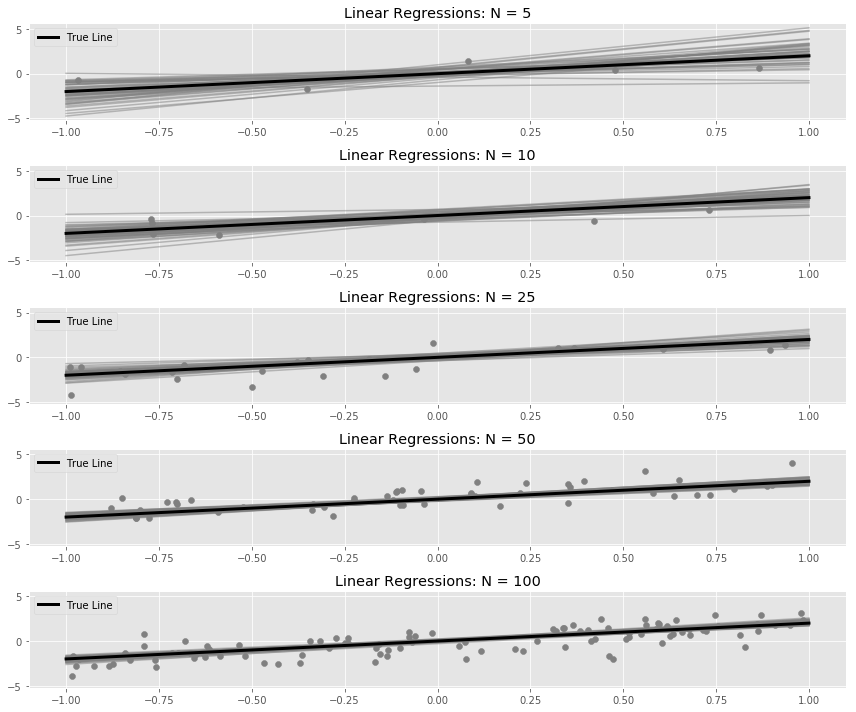

In [20]:
ns = [5, 10, 25, 50, 100]

fig, axs = plt.subplots(len(ns), figsize=(12, 10), sharey=True)
for ax, n in zip(axs, ns):
    plot_regressions(ax, n)
    ax.plot([-1, 1], [-2, 2], color="black", linewidth=3, label="True Line")
    ax.set_title(f"Linear Regressions: N = {n}")
    ax.legend()
fig.tight_layout()

Linear regression is consistent as long as the **data** is independent.

This is essentially what independence is **for**.  When data is independent, each additional data point gives us **more information**, which allows us to better estimate the regression line.

## Normality of Errors: Distribution of Parameter Estimates

The **most information we could possibly have** about the probabalistic nature of linear regression is to know the **distribution of the parameter estiamtes / coefficients**.

### What This Means

It's important to disentangle what this means.

The parameter estimates / coefficients from a fit linear regression are **random quantities**.  If we have different sample of data from our population, fitting a linear regression will give us slightly different results.

$$ \hat \beta \text{ is a random variable!} $$

**Note:** We have already observed that when the data is independent, more data will cause these different results to converge to the same answer.  This is consistency!

The most we could ask for is a complete description of the distribution of the coefficients.  This is available in some circumstances, but it **requires very stringent assumptions**!

In [79]:
def run_one_regression(n, noise=np.random.normal):
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-0.5, 0.5, size=n)
    x3 = np.random.uniform(-2, 2, size=n)
    y = 1 + x1 - 2*x2 + noise(size=n)
    X = np.empty(shape=(n, 3))
    X[:, 0] = x1; X[:, 1] = x2; X[:, 2] = x3
    model = LinearRegression()
    model.fit(X, y)
    return X, y, model.coef_

def simulate_many_coeffs(n, n_sim=5000, noise=np.random.normal):
    coeffs = np.empty(shape=(n_sim, 3))
    for i in range(n_sim):
        _, _, coeffs[i, :] = run_one_regression(n, noise=noise)
    return coeffs

def plot_paramter_estimate_histograms(axs, coeffs):
    axs[0].hist(coeffs[:, 0], bins=100, color="grey", alpha=0.5, 
                density=True, label="Parameter Estimates: Observed")
    axs[0].set_title(r"Distribution of $\hat \beta_1$")
    axs[0].axvline(1, color="black", label=r"True Parameter $\beta_1$")
    axs[0].legend()

    axs[1].hist(coeffs[:, 1], bins=100, color="grey", alpha=0.5,
                density=True, label="Parameter Estimates: Observed")
    axs[1].set_title(r"Distribution of $\hat \beta_2$")
    axs[1].axvline(-2, color="black", label=r"True Parameter $\beta_2$")
    axs[1].legend()


    axs[2].hist(coeffs[:, 2], bins=100, color="grey", alpha=0.5,
                density=True, label="Parameter Estimates: Observed")
    axs[2].set_title(r"Distribution of $\hat \beta_3$")
    axs[2].axvline(0, color="black", label=r"True Parameter $\beta_3$")
    axs[2].legend()

In [80]:
X, y, _ = run_one_regression(10, noise=np.random.normal)
coeffs = simulate_many_coeffs(10, noise=np.random.normal)

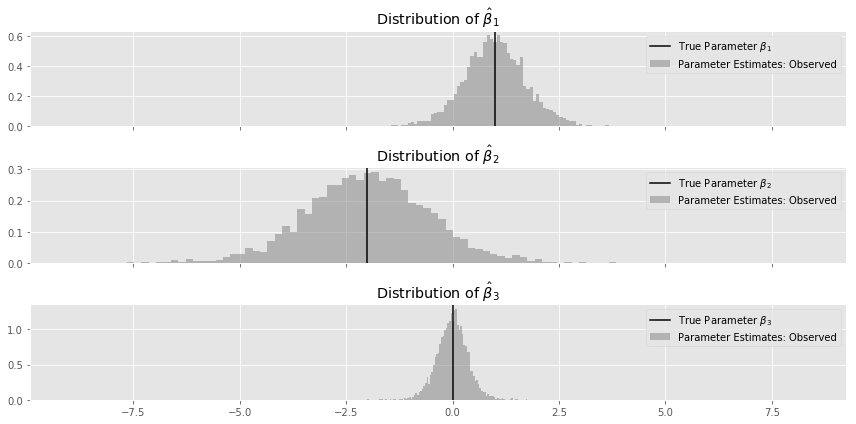

In [81]:
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)
plot_paramter_estimate_histograms(axs, coeffs)
fig.tight_layout()

The usual assumption / consequence is this:

**When the noise is assumed to be normally distributed (centered at zero, variance does not depend on x), then the parameter estiamtes are ALSO normally distributed**.

We can write that assumption in rigorous notation as:

$$ y \mid x \sim \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k + \text{Normal}(0, \sigma) $$

Sigma here must **not depend on $x$**.  This specific property is called **heteroskedacity**.

We can compute the means and varainces of the resulting normal distributions.

### The Mean of the Parameter Estiamte Distributions

As is evident from the plots above, the **mean** of the parameter estimate distributions **is the true parameters**.  This is nice!  This property is called **unbiasedness**.

### The Varaince of the Parameter Estiamate Distribution

The variance of the parameter estiamte distribution is not so easy to describe, but it is computable.

The variance of $\hat \beta_k$ can be found as the $(k, k)$-th entry (i.e. the $k$-th diagonal entry) in the matrix:

$$ \Sigma^{-1} = \sigma (X^t X)^{-1} $$

**Note:** This is the **only** use case I know of where it is appropriate to compute the inverse of a matrix.

In [68]:
# We need X to have an intercept column for this to be valid...
X_with_intercept = np.zeros((X.shape[0], X.shape[1] + 1))
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:] = X

S = np.linalg.inv(X_with_intercept.T @ X_with_intercept)

In [86]:
def plot_coefficient_distributions(axs, means, variances):
    t = np.linspace(-8, 8, num=250)
    for ax, mu, sigma_sq in zip(axs, means, variances):
        dist = stats.norm(mu, np.sqrt(sigma_sq))
        ax.plot(t, dist.pdf(t), color="black", linestyle="--",
                label="Parameter Estiamtes: Theoretical")
        ax.legend()

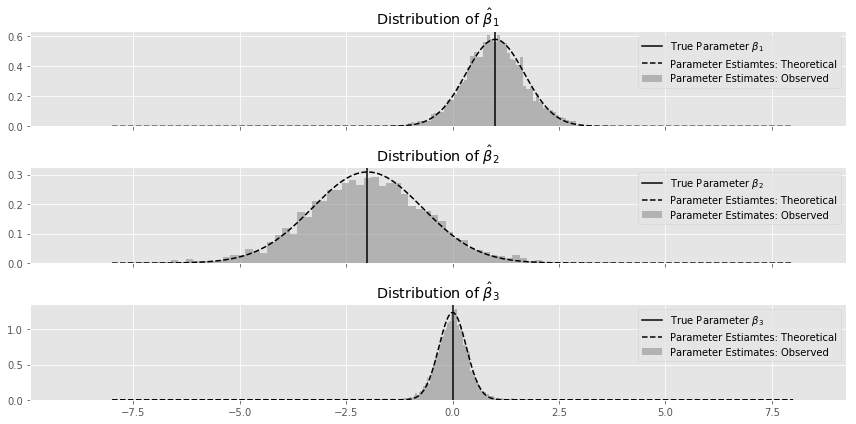

In [87]:
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)

plot_paramter_estimate_histograms(axs, coeffs)
plot_coefficient_distributions(axs, [1, -2, 0], np.diagonal(S)[1:])

fig.tight_layout()

## Applicatons to Inference

The most common application of all these ideas is in the hypothesis testing of regression coefficeints.

Let's use our model of insect wing sizes to answer an inferential question: 

> Does continent have any effect on wing size?

To accomplish this, we need to pre-sepcify a regression model relating the wing size of insects to all other relevent measurement.  We've already done this work, so I'll just remind everyone of our final model:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent} $$

Then the new number $e$ captures the effect of the insect being found on the continent labeled $1$.  **If $e$ is zero, or close to zero, then continent has no effect on wing span**.

Let's reload the data:

In [93]:
insects = pd.read_csv('./data/insects.csv', sep='\t')
insects.head()

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0


Let's estimate the model:

In [95]:
insects_model_quad_with_continent = GLM(family=Gaussian())
insects_model_quad_with_continent.fit(
    insects,
    formula='wingsize ~ latitude + I(latitude**2) + sex + continent')
insects_model_quad_with_continent.summary()

Gaussian GLM Model Summary.
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept               1945.39           91.51
latitude                 -42.96            3.88
I(latitude ** 2)           0.45            0.04
sex                      -89.90            3.81
continent                 -4.11            3.58


Those `standard errors` are what we computed with our $\sigma (X^t X)^{-1}$ calculation.

## Linear Regression p-values

Recall that a **p-value** describes the amount of surprise that we feel when observing data, given that we are taking a skeptical stance on how that data is generated.

$$ P(\text{Observing A Statistic Equal or More Extreme than Actual} \mid H_0) $$

So to make sense of the p-values here, we need to describe the **null hypothesis** and the **statistic**.

The **null hypothesis** in this case is that each value of $y$ was generated by sampling from a relationship like:

$$ y \mid x \sim N(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + 0 \times \text{Continent}, \sigma) $$

Notice that in the null hypothesis, we are assuming **the effect of continent is zero, so we would be surprised to find it very non-zero**.

Given this null hypothesis, the **p-value** reported in linear regression is

$$ P(\text{Observe a Parameter Estimate for Continent More Extreme Than the Fit Model} \mid H_0) $$

We can extract the p-values from our fit regression model with the `_p_value` attribute:

In [98]:
names = insects_model_quad_with_continent.X_names
p_values = insects_model_quad_with_continent.p_values_

print("Predictor            p-value")
print("-"*30)
for name, p in zip(names, p_values):
    print(f"{name :<20} {p:2.3f}")

Predictor            p-value
------------------------------
Intercept            0.000
latitude             0.000
I(latitude ** 2)     0.000
sex                  0.000
continent            0.251


Our p-value for continent was $0.25$, so it's quite likely that we would observe a parameter estimate equally or more extreme than we actually did, even if the true effect was zero.  This is consistent with what we saw in our picture, we do **not** believe that `continent` has an effect much different than zero.

## A Final Word on Assumptions

There is a subtlety to our hypothesis test above.

The Null Hypothesis can be **false in more than one way**:

  - It could be, as we discussed already, that the true effect of `continent` is *not-zero*.  This is the situation we are trying to detect.
  - It could be that the value of $y$ was **not created by sampling from a normal distribution centered at the predicted value**.
  
For example, it could be that the value of $y$ was created by sampling from some other distribution:

$$ y \mid x \sim \text{Exponential}(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent}) $$

In this case we **cannot deduce that $e \neq 0$, even if we reject the null hypothesis**.

**The calculation of p-values in a linear regression depends on ALL THE ASSUMPTIONS ABOVE being true**.  If **any** of them are false, the calculation of the p-value is **not valid**.